# Visualizing MNIST with a Deep Variational Autoencoder

1. Introduction  
    A. What is autoencoding?  
    B. Autoencoders  
    C. The Variational Variety  
2. Data preparation  
    A. Load data   
    B. Reshape & normalize  
3. Model construction  
    A. Encoder network  
    B. Sampling function  
    C. Decoder network  
    D. Loss
4. Train the VAE
5. Results  
    A. Clustering of digits in the latent space  
    B. Sample digits

## *1. Introduction*
Variational Autoencoders (VAEs) can be used to visualize high-dimensional data in a meaningful, lower-dimensional space. In this kernel, I go over some details about autoencoding and autoencoders, especially VAEs, before constructing and training a deep VAE on the MNIST data from the Digit Recognizer competition. We'll see how the data cluster in the lower-dimensional space according to their digit class. Plotting the test set data in this space shows where the images with unknown digit classes fall with respect to the known digit classes.

The code here borrows heavily from Fran&ccedil;ois Chollet's example VAE from his book [Deep Learning with Python](https://www.amazon.com/Deep-Learning-Python-Francois-Chollet/dp/1617294438/ref=sr_1_1?ie=UTF8&qid=1520470984&sr=8-1&keywords=francois+chollet). You can find a repo of examples from the book (including the one that inspired this kernel) [here on GitHub](https://github.com/brilliantFire/deep-learning-with-python-notebooks).

### *A. What is autoencoding?*
Autoencoding is much like what it sounds in the sense that the input and 'output' are essentially the same. It's an algorithm for data compression where the functions for compression and decompression are *learned from the data*. It's considered more of a *semi-supervised* learning method as opposed to a truly *unsupervised* one since it's not entirely 'targetless'. Instead it learns the targets from the data itself.

Despite all this talk of data compression, autoencoders aren't typically used for that purpose. In practice, you're much more likely to see them being used to preprocess data (as in denoising - think images but it doesn't have to be ;) ) or for dimensionality reduction. In fact, the hidden layers of simple autoencoders are doing something like principal component analysis (PCA), another method traditionally used for dimensionality reduction.

### *B. Autoencoders*
Generally autoencoders have three parts: an encoder, a decoder, and a 'loss' function that maps one to the other. For the simplest autoencoders - the sort that compress and then reconstruct the original inputs from the compressed representation - we can think of the 'loss' as describing the amount of information lost in the process of reconstruction. Typically when people are talking about autoencoders, they're talking about ones where the encoders and decoders are neural networks (in our case deep convnets). In training the autoencoder, we're optimizing the parameters of the neural networks to minimize the 'loss' (or distance) and we do that by stochastic gradient descent (yet another topic for another post). 

### *C. The Variational Variety*
There's a bunch of different kinds of autoencoders but for this post I'm going to concentrate on one type called a *variational autoencoder*. Variational autoencoders (VAEs) don't learn to morph the data in and out of a compressed representation of itself like the 'vanilla' autoencoders I described above. Instead, they learn the parameters of the probability distribution that the data came from. These types of autoencoders have much in common with latent factor analysis (if you know something about that). The encoder and decoder learn models that are in terms of underlying, unobserved *latent* variables. It's essentially an inference model and a generative model daisy-chained together.

![A variational autoencoder](https://i.imgur.com/ZN6MyTx.png)

VAEs have received a lot of attention because of their *generative* ability (though they seem to be falling out of fashion in favor of general adversarial networks, or GANs, in that regard). Since they learn about the distribution the inputs came from, we can sample from that distribution to generate novel data. As we'll see, VAEs can also be used to cluster data in useful ways.

## 2. *Data preparation*  
### *A. Load Data*

In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
%matplotlib inline

from scipy.stats import norm

import keras
from keras.datasets import mnist
from keras.layers import Input, Reshape, Conv2D, Conv2DTranspose, Flatten, Dense, Lambda
from keras.models import Model
from keras import metrics
from keras import backend as K   # 'generic' backend so code works with either tensorflow or theano

K.clear_session()
np.random.seed(237)

2022-05-19 11:08:37.043827: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-05-19 11:08:37.044193: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


AttributeError: module 'keras.engine.base_layer' has no attribute 'BaseRandomLayer'

In [ ]:
# Load Dataset
(X_train, Y_train), (X_valid, Y_valid) = mnist.load_data()

In [ ]:
X_train.shape

(60000, 28, 28)

### dataset description
The MNIST dataset is a built-in dataset provided by Keras. It consists of 70,000 28x28 grayscale images, each of which displays a single handwritten digit from 0 to 9. The training set consists of 60,000 images, while the test set has 10,000 images.

### *2. Reshape & normalize*
Our encoder and decoder are deep convnets constructed using the Keras Functional API. We'll need to separate the inputs from the labels, normalize them by dividing the max pixel value, and reshape them into 28x28 pixel images.

In [5]:
# Normalize and reshape
X_train = X_train.astype('float32') / 255.
X_train = X_train.reshape(-1,28,28,1)

X_valid = X_valid.astype('float32') / 255.
X_valid = X_valid.reshape(-1,28,28,1)

We can take a look at a few random images. The bottom right panel shows one of the more difficult-to-classify digits (even for humans!).

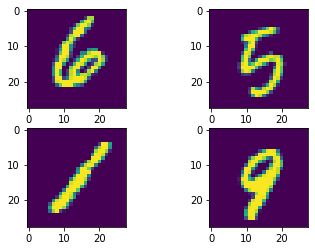

In [6]:
plt.figure(1)
plt.subplot(221)
plt.imshow(X_train[13][:,:,0])

plt.subplot(222)
plt.imshow(X_train[690][:,:,0])

plt.subplot(223)
plt.imshow(X_train[2375][:,:,0])

plt.subplot(224)
plt.imshow(X_train[42013][:,:,0])
plt.show()

## 3. *Model construction*
### *A. Encoder network*
A VAE has three basic parts:  

1. An encoder that that learns the parameters (mean and variance) of the underlying latent distribution;  
2. A means of sampling from that distribution; and,  
3. A decoder that can turn the sample from #2 back into an image.  

In this example, both the encoder and decoder networks are deep convnets. You'll notice that the encoder below has two output layers, one for the latent distribution mean (z_mu) and the other for its variance (z_log_sigma).

In [7]:
img_shape = (28, 28, 1)    # for MNIST
batch_size = 16
latent_dim = 2  # Number of latent dimension parameters

# Encoder architecture: Input -> Conv2D*4 -> Flatten -> Dense
input_img = Input(shape=img_shape)

x = Conv2D(32, 3, padding='same', activation='relu')(input_img)
x = Conv2D(64, 3, padding='same', activation='relu', strides=(2, 2))(x)
x = Conv2D(64, 3, padding='same', activation='relu')(x)
x = Conv2D(64, 3, padding='same', activation='relu')(x)
# need to know the shape of the network here for the decoder
shape_before_flattening = K.int_shape(x)

x = Flatten()(x)
x = Dense(32, activation='relu')(x)

# Two outputs, latent mean and (log)variance
z_mu = Dense(latent_dim)(x)
z_log_sigma = Dense(latent_dim)(x)

2022-05-18 23:46:29.982344: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-05-18 23:46:29.985127: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-05-18 23:46:29.987004: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (LAPTOP-K0HP3GCL): /proc/driver/nvidia/version does not exist
2022-05-18 23:46:29.996617: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


### *B. Sampling function*
Next, we create a function to sample from the distribution we just learned the parameters of. `epsilon` is a tensor of small random normal values. One of the assumptions underlying a VAE like this is that our data arose from a random process and is normally distributed in the latent space.

With Keras, everything has to be in a 'layer' to compile correctly. This goes for our sampling function. The `Lambda` layer wrapper let's us do this.

In [8]:
# sampling function
def sampling(args):
    z_mu, z_log_sigma = args
    epsilon = K.random_normal(shape=(K.shape(z_mu)[0], latent_dim),
                              mean=0., stddev=1.)
    return z_mu + K.exp(z_log_sigma) * epsilon

# sample vector from the latent distribution
z = Lambda(sampling)([z_mu, z_log_sigma])

### *C. Decoder network*
The decoder is basically the encoder in reverse.

In [9]:
# decoder takes the latent distribution sample as input
decoder_input = Input(K.int_shape(z)[1:])

# Expand to 784 total pixels
x = Dense(np.prod(shape_before_flattening[1:]), activation='relu')(decoder_input)

# reshape
x = Reshape(shape_before_flattening[1:])(x)

# use Conv2DTranspose to reverse the conv layers from the encoder
x = Conv2DTranspose(32, 3, padding='same', activation='relu', strides=(2, 2))(x)
x = Conv2D(1, 3, padding='same', activation='sigmoid')(x)

# decoder model statement
decoder = Model(decoder_input, x)

# apply the decoder to the sample from the latent distribution
z_decoded = decoder(z)

### *D. Loss*
We need one more thing and that's something that will calculate the unique loss function the VAE requires. Recall that the VAE is trained using a loss function with two components:  

1. 'Reconstruction loss' - This is the cross-entropy describing the errors between the decoded samples from the latent distribution and the original inputs.  
2. The Kullback-Liebler divergence between the latent distribution and the prior (this acts as a sort of regularization term).  

We define a custom layer class that calculates the loss. 

In [10]:
# construct a custom layer to calculate the loss
class CustomVariationalLayer(keras.layers.Layer):

    def vae_loss(self, x, z_decoded):
        x = K.flatten(x)
        z_decoded = K.flatten(z_decoded)
        # Reconstruction loss
        xent_loss = metrics.binary_crossentropy(x, z_decoded)
        # KL divergence
        kl_loss = -5e-4 * K.mean(1 + z_log_sigma - K.square(z_mu) - K.exp(z_log_sigma), axis=-1)
        return K.mean(xent_loss + kl_loss)

    # adds the custom loss to the class
    def call(self, inputs):
        x = inputs[0]
        z_decoded = inputs[1]
        loss = self.vae_loss(x, z_decoded)
        self.add_loss(loss, inputs=inputs)
        return x

# apply the custom loss to the input images and the decoded latent distribution sample
y = CustomVariationalLayer()([input_img, z_decoded])

Now we can instantiate the model and take a look at its summary.

In [11]:
# VAE model statement
vae = Model(input_img, y)
vae.compile(optimizer='rmsprop', loss=None)
vae.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 28, 28, 32)   320         ['input_1[0][0]']                
                                                                                                  
 conv2d_1 (Conv2D)              (None, 14, 14, 64)   18496       ['conv2d[0][0]']                 
                                                                                                  
 conv2d_2 (Conv2D)              (None, 14, 14, 64)   36928       ['conv2d_1[0][0]']               
                                                                                            

## 4. *Train the VAE*
Finally, we fit the model.

In [12]:
num_epochs = 10

In [2]:
import tensorflow as tf
print(tf.version.VERSION)

2.5.0


In [14]:
vae.fit(x=X_train, y=None, shuffle=True, epochs=num_epochs, batch_size=batch_size, validation_data=(X_valid, None))

2022-05-18 23:46:36.577360: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 188160000 exceeds 10% of free system memory.


Epoch 1/10


TypeError: in user code:

    File "/home/cyy/.local/lib/python3.9/site-packages/keras/engine/training.py", line 1021, in train_function  *
        return step_function(self, iterator)
    File "/home/cyy/.local/lib/python3.9/site-packages/keras/engine/training.py", line 1010, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/home/cyy/.local/lib/python3.9/site-packages/keras/engine/training.py", line 1000, in run_step  **
        outputs = model.train_step(data)
    File "/home/cyy/.local/lib/python3.9/site-packages/keras/engine/training.py", line 860, in train_step
        loss = self.compute_loss(x, y, y_pred, sample_weight)
    File "/home/cyy/.local/lib/python3.9/site-packages/keras/engine/training.py", line 918, in compute_loss
        return self.compiled_loss(
    File "/home/cyy/.local/lib/python3.9/site-packages/keras/engine/compile_utils.py", line 239, in __call__
        self._loss_metric.update_state(
    File "/home/cyy/.local/lib/python3.9/site-packages/keras/utils/metrics_utils.py", line 70, in decorated
        update_op = update_state_fn(*args, **kwargs)
    File "/home/cyy/.local/lib/python3.9/site-packages/keras/metrics.py", line 178, in update_state_fn
        return ag_update_state(*args, **kwargs)
    File "/home/cyy/.local/lib/python3.9/site-packages/keras/metrics.py", line 471, in update_state  **
        update_total_op = self.total.assign_add(value_sum)
    File "/home/cyy/.local/lib/python3.9/site-packages/keras/engine/keras_tensor.py", line 254, in __array__
        raise TypeError(

    TypeError: You are passing KerasTensor(type_spec=TensorSpec(shape=(), dtype=tf.float32, name=None), name='tf.math.reduce_sum/Sum:0', description="created by layer 'tf.math.reduce_sum'"), an intermediate Keras symbolic input/output, to a TF API that does not allow registering custom dispatchers, such as `tf.cond`, `tf.function`, gradient tapes, or `tf.map_fn`. Keras Functional model construction only supports TF API calls that *do* support dispatching, such as `tf.math.add` or `tf.reshape`. Other APIs cannot be called directly on symbolic Kerasinputs/outputs. You can work around this limitation by putting the operation in a custom Keras layer `call` and calling that layer on this symbolic input/output.


## 5. *Results*  
### *A. Clustering of digits in the latent space*
We can make predictions on the validation set using the encoder network. This has the effect of translating the images from the 784-dimensional input space into the 2-dimensional latent space. When we color-code those translated data points according to their *known* digit class, we can see how the digits cluster together.

In [ ]:
# Translate into the latent space
encoder = Model(input_img, z_mu)
X_valid_encoded = encoder.predict(X_valid, batch_size=batch_size)
plt.figure(figsize=(10, 10))
plt.scatter(X_valid_encoded[:, 0], X_valid_encoded[:, 1], c=Y_valid, cmap='brg')
plt.colorbar()
plt.show()

Including the original test set data lets us see where they fall with respect to the known digit clusters.

In [ ]:
# set colormap so that 11's are gray
custom_cmap = matplotlib.cm.get_cmap('brg')
custom_cmap.set_over('gray')

X_valid_encoded = encoder.predict(X_valid, batch_size=batch_size)
plt.figure(figsize=(10, 10))
gray_marker = mpatches.Circle(4,radius=0.1,color='gray', label='Test')
plt.legend(handles=[gray_marker], loc = 'best')
plt.scatter(X_valid_encoded[:, 0], X_valid_encoded[:, 1], c=Y_valid, cmap=custom_cmap)
plt.clim(0, 9)
plt.colorbar()

### *B. Sample digits*
Another fun thing we can do is to use the decoder network to take a peak at what samples from the latent space look like as we change the latent variables. What we end up with is a smoothly varying space where each digit transforms into the others as we dial the latent variables up and down.

In [ ]:
# Display a 2D manifold of the digits
n = 20  # figure with 20x20 digits
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))

# Construct grid of latent variable values
grid_x = norm.ppf(np.linspace(0.05, 0.95, n))
grid_y = norm.ppf(np.linspace(0.05, 0.95, n))

# decode for each square in the grid
for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        Z_sample = np.array([[xi, yi]])
        Z_sample = np.tile(Z_sample, batch_size).reshape(batch_size, 2)
        X_decoded = decoder.predict(Z_sample, batch_size=batch_size)
        digit = X_decoded[0].reshape(digit_size, digit_size)
        figure[i * digit_size: (i + 1) * digit_size,
               j * digit_size: (j + 1) * digit_size] = digit

plt.figure(figsize=(10, 10))
plt.imshow(figure, cmap='gnuplot2')
plt.show()  